In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2
import math
import csv
from PIL import Image
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.applications import VGG19
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime

Using TensorFlow backend.
c:\users\robotics\anaconda3\envs\faster_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\robotics\anaconda3\envs\faster_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\robotics\anaconda3\envs\faster_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\robotics\an

In [2]:
ratio = 4
channels = 3
HR_size = np.array([480,640])#
LR_size = HR_size // ratio
H_h = HR_size[0]
H_w = HR_size[1]
L_h = LR_size[0]
L_w = LR_size[1]
print(HR_size[0])
print(LR_size)

480
[120 160]


In [3]:
class DataLoader():
    def __init__(self):
        pass
#         self.ratio = ratio
#         self.HR_size = HR_size
#         self.LR_size = HR_size / ratio
#         self.H_h = HR_size[0]
#         self.H_w = HR_size[1]
#         self.L_h = LR_size[0]
#         self.L_h = LR_size[1]
        
    
    
    def load_data(self, batch_size = 1):
        files = glob.glob("../../images/train/*.png", recursive=True)
        batch_images = random.sample(files, batch_size)
    
        HR_images = []
        LR_images = []
    
        for img_path in batch_images:
            img = Image.open(img_path)

            HR_image = img.resize((H_w, H_h))  #(64, 64)
            LR_image = img.resize((L_w, L_h))
            HR_image = np.array(HR_image)
            #img_hr = (img_hr - 127.5) / 127.5
            LR_image = np.array(LR_image)
            #img_lr = (img_lr - 127.5) / 127.5

#             if not is_testing and np.random.random() < 0.5:
#                 img_hr = np.fliplr(img_hr)
#                 img_lr = np.fliplr(img_lr)

            HR_images.append(HR_image)
            LR_images.append(LR_image)
        
        HR_images = np.array(HR_images) / 127.5 - 1
        LR_images = np.array(LR_images) / 127.5 - 1
        
        return HR_images, LR_images

#------------------------------------------------------------------#
  
#------------------------------------------------------------------#

class predDataLoader():          
    def load_data(self, batch_size, counter):
        random.seed(counter)
        np.random.seed(counter)

        files = glob.glob("../../images/test/*.png", recursive=True)
        batch_images = random.sample(files, batch_size)

        imgs_or = []
        for img_path in batch_images:
            img = Image.open(img_path)

            img_or = np.array(img)
            imgs_or.append(img_or)

        imgs_or = np.array(imgs_or) / 127.5 - 1.

        return imgs_or
    
    
#------------------------------------------------------------------#
  
#------------------------------------------------------------------#

class SRGAN():
    def __init__(self):
        
        # Input shape
#         self.channels = 3
#         self.lr_height = 288                 # Low resolution height
#         self.lr_width = 384                  # Low resolution width
#         self.lr_shape = (self.lr_height, self.lr_width, self.channels)
#         resLevel = 2 #
#         self.hr_height = self.lr_height*resLevel  # High resolution height
#         self.hr_width = self.lr_width*resLevel     # High resolution width
#         self.hr_shape = (self.hr_height, self.hr_width, self.channels)

        #残差ブロックの数
        # Number of residual blocks in the generator
        self.n_residual_blocks = 16 #

        optimizer = Adam(0.0002, 0.5)

        #img_hrの特徴量をVGG19で算出する
        # We use a pre-trained VGG19 model to extract image features from the high resolution
        # and the generated high resolution images and minimize the mse between them
        self.VGG = self.build_vgg()
        self.VGG.trainable = False
        self.VGG.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        
        #データはここで読み込まれる
        # Configure data loader
        #self.dataset_name = 'img_align_celeba'
        self.data_loader = DataLoader()
        self.pred_data_loader = predDataLoader()

        #Dのサイズ
        # Calculate output shape of D (PatchGAN)
        patchH = int(H_h / 2**4) #
        patchW = int(H_w / 2**4) #
        self.disc_patch = (patchH, patchW, 1) 

        #DとGのチャンネル設定
        # Number of filters in the first layer of G and D
        self.gf = 60 #gf
        self.df = 60 #df
        #Dビルドとコンパイル
        # Build and compile the discriminator
        self.Discriminator = self.build_discriminator()
        self.Discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #Gのビルド
        # Build the generator
        self.Generator = self.build_generator()

        # High res. and low res. images
        HR_image = Input(shape = (H_h, H_w, channels))
        LR_image = Input(shape = (L_h, L_w, channels))

        #Gで生成されたhrのimg
        # Generate high res. version from low res.
        SR_image = self.Generator(LR_image)

        #hrのimgの特徴量の算出
        # Extract image features of the generated img
        SR_features = self.VGG(SR_image)

        # For the combined model we will only train the generator
        self.Discriminator.trainable = False

        #学習モデルコンパイル
        # Discriminator determines validity of generated high res. images
        validity = self.Discriminator(SR_image)

        self.combined = Model([LR_image, HR_image], [validity, SR_features])
        self.combined.compile(loss=['binary_crossentropy', 'mse'],
                              loss_weights=[1e-3, 1],
                              optimizer=optimizer)
        
    #------------------------------------------------------------------#
    
    def build_vgg(self):
        """
        Builds a pre-trained VGG19 model that outputs image features extracted at the
        third block of the model
        """
        VGG = VGG19(weights="imagenet")
        # Set outputs to outputs of last conv. layer in block 3
        # See architecture at: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
        VGG.outputs = [VGG.layers[9].output]

        img = Input(shape = (H_h, H_w, channels))

        # Extract image features
        img_features = VGG(img)

        return Model(img, img_features)
    
    #------------------------------------------------------------------#
    
    #Generator の実装
    def build_generator(self):

        #残差ブロックの中身
        def residual_block(layer_input, n_filters):
            """Residual block described in paper"""
            d = Conv2D(n_filters, kernel_size=3, strides=1, padding='same')(layer_input)
            d = Activation('relu')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Conv2D(n_filters, kernel_size=3, strides=1, padding='same')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Add()([d, layer_input])
            return d

        #解像度を2倍にするUpSampling
        def deconv2d(layer_input):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input) #
            u = Conv2D(120, kernel_size=3, strides=1, padding='same')(u) #
            u = Activation('relu')(u)
            return u

        # Low resolution image input
        img_lr = Input(shape = (L_h, L_w, channels))

        # Pre-residual block
        c1 = Conv2D(60, kernel_size=9, strides=1, padding='same')(img_lr) #
        c1 = Activation('relu')(c1)

        # Propogate through residual blocks
        r = residual_block(c1, self.gf)
        for _ in range(self.n_residual_blocks - 1):
            r = residual_block(r, self.gf)

        #去の残差ブロックと組み合わせる
        # Post-residual block
        c2 = Conv2D(60, kernel_size=3, strides=1, padding='same')(r) #
        c2 = BatchNormalization(momentum=0.8)(c2)
        c2 = Add()([c2, c1])

        # Upsampling
        n = ratio
        while(n % 2 == 0):
            c2 = deconv2d(c2)
            n = n // 2

        # Generate high resolution output
        gen_hr = Conv2D(channels, kernel_size=9, strides=1, padding='same', activation='tanh')(c2)

        return Model(img_lr, gen_hr)
    
    
    #------------------------------------------------------------------#
    
    #Discriminator の実装
    def build_discriminator(self):

        
        def d_block(layer_input, filters, strides=1, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        # Input img
        d0 = Input(shape = (H_h, H_w, channels))
        #畳み込み層、チャンネル数を最終的に16倍に
        d1 = d_block(d0, self.df, bn=False)
        d2 = d_block(d1, self.df, strides=2)
        d3 = d_block(d2, self.df*2)
        d4 = d_block(d3, self.df*2, strides=2)
        d5 = d_block(d4, self.df*4)
        d6 = d_block(d5, self.df*4, strides=2)
        d7 = d_block(d6, self.df*8)
        d8 = d_block(d7, self.df*8, strides=2)
        #この時点で画像サイズ1/16
        d9 = Dense(self.df*16)(d8)
        d10 = LeakyReLU(alpha=0.2)(d9)
        validity = Dense(1, activation='sigmoid')(d10)

        return Model(d0, validity)
    
    
    #------------------------------------------------------------------#
    
    
    #学習
    def train(self, epochs, batch_size, sample_interval=100):

        start_time = datetime.datetime.now()
        psnr_file = open('psnr.csv' , 'w+')
        psnr_file.close()

        for epoch in range(epochs):

            # ----------------------
            #  Train Discriminator
            # ----------------------

            # Sample images and their conditioning counterparts
            HR_images, LR_images = self.data_loader.load_data(batch_size)

            # From low res. image generate high res. version
            SR_images = self.Generator.predict(LR_images)

            valid = np.ones((batch_size,) + self.disc_patch)
            fake = np.zeros((batch_size,) + self.disc_patch)

            #Dのloss
            # Train the discriminators (original images = real / generated = Fake)
            d_loss_real = self.Discriminator.train_on_batch(HR_images, valid)
            d_loss_fake = self.Discriminator.train_on_batch(SR_images, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ------------------
            #  Train Generator
            # ------------------

            # Sample images and their conditioning counterparts
           
            HR_images, LR_images = self.data_loader.load_data(batch_size)

            # The generators want the discriminators to label the generated images as real
            valid = np.ones((batch_size,) + self.disc_patch)

            # Extract ground truth image features using pre-trained VGG19 model
            image_features = self.VGG.predict(HR_images)

            # Train the generators
            g_loss = self.combined.train_on_batch([LR_images, HR_images], [valid, image_features])

            elapsed_time = datetime.datetime.now() - start_time
            # Plot the progress
            print ("%d time: %s" % (epoch, elapsed_time))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
                self.Generator.save_weights('srg_weight.h5')
                
                
                
                
    #------------------------------------------------------------------#
    
            
    def sample_images(self, epoch):
        def denormalize(input_data):
            input_data = (input_data + 1) * 127.5
            return input_data.astype(np.uint8)
        os.makedirs('../../images/images/%s' , exist_ok=True)
        r, c = 2, 2

        HR_images, LR_images = self.data_loader.load_data(batch_size=2)
        SR_images = self.Generator.predict(LR_images)

        LR_images = denormalize(LR_images)
        SR_images = denormalize(SR_images)
        HR_images = denormalize(HR_images)

        def psnr_calc(img1: np.ndarray, img2: np.ndarray, upscaling=2):
            def convert(img):
                return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            def extract_y(image: np.ndarray) -> np.ndarray:
                if image.ndim == 2:
                    return image
                image = image.astype(np.int32)
                return ((image[:, :, 2] * 65.481 / 255.
                          + image[:, :, 1] * 128.553 / 255.
                          + image[:, :, 0] * 24.966 / 255.) + 16).astype(np.int32)


            def psnr(img1, img2):
                mse = np.mean((img1 - img2) ** 2)
                if mse == 0:
                    return 100
                PIXEL_MAX = 255.0
                return 10 * math.log10(PIXEL_MAX * PIXEL_MAX / mse)
  
            img1_conv=convert(img1)
            img2_conv=convert(img2)
  
            # BGR -> YCrCb
            # 画像はcv2.imreadで読まれている前提 [0, 255]
            y1 = extract_y(img1_conv)
            y2 = extract_y(img2_conv)
            # 周囲のcropping
            # assert y1.shape == y2.shape
            h, w = y1.shape
            cr = upscaling
            cropped_y1 = y1[cr:h - cr, cr:w - cr].astype(np.float64)
            cropped_y2 = y2[cr:h - cr, cr:w - cr].astype(np.float64)

            # psnr
            psnr_val = psnr(cropped_y1, cropped_y2)
            return psnr_val
        
        
        # Save generated images and the high resolution originals
        titles = ['Generated', 'Original']

        cv2.imwrite("../../images/images/hreal_img_0.png",HR_images[0])
        cv2.imwrite("../../images/images/hreal_img_1.png",HR_images[1])
        cv2.imwrite("../../images/images/lreal_img_0.png",LR_images[0])
        cv2.imwrite("../../images/images/lreal_img_1.png",LR_images[1])
        # size=(480,480)

        for i in range(r):
            psnr = psnr_calc(HR_images[i],SR_images[i])
            print(psnr)
            data =[epoch,psnr]
            psnr_file = open('psnr.csv' , 'a')
            writer = csv.writer(psnr_file, lineterminator='\n')  
            writer.writerow(data)
            psnr_file.close()
            cv2.imwrite("../../images/images/{}_{}img_pred.png".format(epoch,i),SR_images[i])
            
            
    #------------------------------------------------------------------#

In [22]:
if __name__ == '__main__':
    gan = SRGAN()
    gan.train(epochs=500, batch_size=1, sample_interval=50)

0 time: 0:00:29.698188
15.38781255866509
16.596670663728652
1 time: 0:01:59.390437
2 time: 0:02:00.012322
3 time: 0:02:00.637394
4 time: 0:02:01.270736
5 time: 0:02:01.884764
6 time: 0:02:02.507765
7 time: 0:02:03.134840
8 time: 0:02:03.753403
9 time: 0:02:04.372472
10 time: 0:02:05.045083
11 time: 0:02:05.674440
12 time: 0:02:06.279991
13 time: 0:02:06.916852
14 time: 0:02:07.552796
15 time: 0:02:08.170124
16 time: 0:02:08.798750
17 time: 0:02:09.424801
18 time: 0:02:10.038863
19 time: 0:02:10.656929
20 time: 0:02:11.287057
21 time: 0:02:11.888603
22 time: 0:02:12.519088
23 time: 0:02:13.149039
24 time: 0:02:13.767074
25 time: 0:02:14.384119
26 time: 0:02:15.011197
27 time: 0:02:15.633265
28 time: 0:02:16.239723
29 time: 0:02:16.873299
30 time: 0:02:17.499869
31 time: 0:02:18.116430
32 time: 0:02:18.747402
33 time: 0:02:19.375402
34 time: 0:02:19.984956
35 time: 0:02:20.613031
36 time: 0:02:21.242604
37 time: 0:02:21.857063
38 time: 0:02:22.482938
39 time: 0:02:23.103540
40 time: 0:02

322 time: 0:05:22.119517
323 time: 0:05:22.738583
324 time: 0:05:23.368792
325 time: 0:05:23.983743
326 time: 0:05:24.605308
327 time: 0:05:25.235882
328 time: 0:05:25.841936
329 time: 0:05:26.464502
330 time: 0:05:27.089071
331 time: 0:05:27.712173
332 time: 0:05:28.335222
333 time: 0:05:28.961330
334 time: 0:05:29.588329
335 time: 0:05:30.198885
336 time: 0:05:30.822452
337 time: 0:05:31.452530
338 time: 0:05:32.069706
339 time: 0:05:32.702283
340 time: 0:05:33.324847
341 time: 0:05:33.930903
342 time: 0:05:34.554948
343 time: 0:05:35.175512
344 time: 0:05:35.785066
345 time: 0:05:36.405631
346 time: 0:05:37.030682
347 time: 0:05:37.651246
348 time: 0:05:38.259304
349 time: 0:05:38.880869
350 time: 0:05:39.503940
22.881361691762034
23.706581853811542
351 time: 0:05:40.555922
352 time: 0:05:41.190630
353 time: 0:05:41.799183
354 time: 0:05:42.421900
355 time: 0:05:43.046468
356 time: 0:05:43.665536
357 time: 0:05:44.281096
358 time: 0:05:44.903166
359 time: 0:05:45.523730
360 time: 0:

In [4]:
with open('psnr.csv') as f:
    reader = csv.reader(f)
    psnr_array1=[]
    psnr_array2=[]
    epoch_array1=[]
    epoch_array2=[]
    cnt=1
    for row in reader:
        if(cnt%2 is 1):
          psnr_array1.append(float(row[1]))
          epoch_array1.append(int(row[0]))
        else:
          psnr_array2.append(float(row[1]))
          epoch_array2.append(int(row[0]))
        cnt+=1

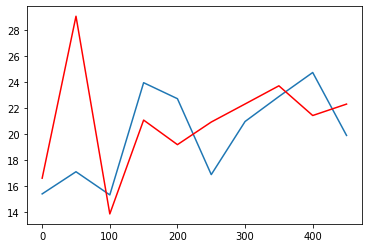

In [5]:
import matplotlib.pyplot as plt
plt.plot(epoch_array1, psnr_array1)
plt.plot(epoch_array2, psnr_array2,color='red')

In [6]:
with open('psnr.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        print(row)

['0', '15.38781255866509']
['0', '16.596670663728652']
['50', '17.09379436967709']
['50', '29.06162284030121']
['100', '15.30965554028815']
['100', '13.847103436853214']
['150', '23.94659212301026']
['150', '21.068808614701']
['200', '22.714795453913993']
['200', '19.179297755904855']
['250', '16.8721941415073']
['250', '20.91897994908676']
['300', '20.961023426988184']
['300', '22.308635528955996']
['350', '22.881361691762034']
['350', '23.706581853811542']
['400', '24.732110286806005']
['400', '21.42081487121116']
['450', '19.888658403135913']
['450', '22.299875816025853']


In [9]:
class Generate(SRGAN):
    def generate(self, batch_size=1, sample_interval=50):
        BATCH_SIZE=1
        ite=10000
        def denormalize(input_data):
            input_data = (input_data + 1) * 127.5
            return input_data.astype(np.uint8)
            
        self.generator = self.build_generator()
        g = self.generator
        g.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
        g.load_weights('srg_weight.h5')
        for i in range(10):
            noise = np.random.uniform(size=[BATCH_SIZE, 480*640*3], low=-1.0, high=1.0)
            imgs_or = self.pred_data_loader.load_data(batch_size=1,counter=i)
            # imgs_hr, imgs_or = self.data_loader.load_data(batch_size=BATCH_SIZE,is_testing=True)

            plt.imshow(denormalize(imgs_or[0]))
            plt.pause(1)
            noise=imgs_or.reshape(BATCH_SIZE,480,640,3)
            generated_images = g.predict(noise)
            plt.imshow(denormalize(generated_images[0]))
            plt.pause(1)
            p_im=Image.fromarray(denormalize(generated_images[0]))
            p_im.save('../../images/output/p_im_{}.png'.format(i))
            # plt.imshow(p_im.resize((120,120)), Image.LANCZOS)

            print(i)
        # os.makedirs(os.path.join(".", "images"), exist_ok=True)
        # image.save("./images/%s%d.png" % (ite,i))            

    def combine_images(generated_images, cols=5, rows=5):
        shape = generated_images.shape
        h = shape[1]
        w = shape[2]
        image = np.zeros((rows * h,  cols * w, 3))
        for index, img in enumerate(generated_images):
            if index >= cols * rows:
                break
            i = index // cols
            j = index % cols
            image[i*h:(i+1)*h, j*w:(j+1)*w, :] = img[:, :, :]
        image = image * 127.5 + 127.5
        image = Image.fromarray(image.astype(np.uint8))
        
        return image

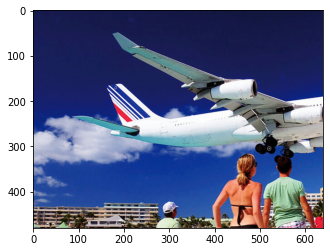

ValueError: Error when checking : expected input_14 to have shape (None, 120, 160, 3) but got array with shape (1, 480, 640, 3)

In [10]:
if __name__ == '__main__':
    gene = Generate()
    gene.generate(batch_size=1, sample_interval=1000)